# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [58]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st

---
## 1. Read the dataset

In [59]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


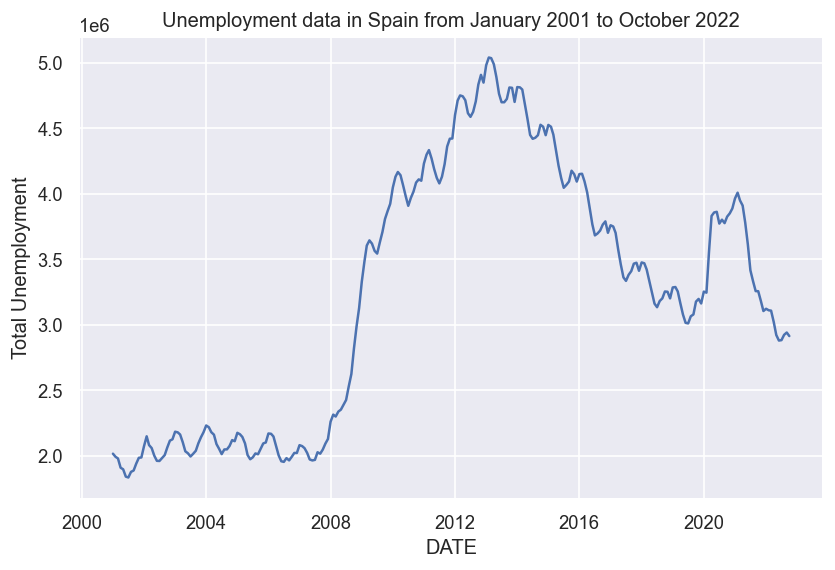

In [60]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2022', xlabel='DATE', ylabel='Total Unemployment')
plt.show()

In [61]:
y = df

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

y_train2 = y.iloc[0:round(0.9*y.shape[0])]
y_test2 = y.iloc[round(0.9*y.shape[0])+1:round(y.shape[0])]

y_train.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


Se divide el dataset en dos subconjuntos de entrenaimento y test. Esto es debido a que el último 20% corresponde al COVID, y si se utilizase un 80/20 sería el conjunto de test el del COVID, dando una sensación falsa de que el modelo es malo, y sin poder captar el verdadero comportamiento de la pandemia. Por ello, si se quieren entrenar modelos, se usan primero los datos sin COVID con una proporción 80/20 (en el total, una relación 64/16). Con ello, se pretende conseguir un modelo que ajuste bien la serie temporal sin comportamientos anómalos y con menos riesgo de sobreajuste que si únicamente se utilizase entrenamiento, ya que se puede comprobar su comportamiento en el test.

Tras eso, se estudia de nuevo la serie en una proporción 90/10 (para que el test no sea todo el COVID) y, basándonos en un modelo que sabemos que no tiene un gran sobreajuste y es decente en predicciones y métricas, se realizan los reajustes necesarios para estos nuevos datos, con la intención de que sea un modelo decente en sus predicciones y sin que peque de sobreajuste.

Tras ello, se aplica el modelo resultante al 100% de los datos para reajustarlo y conseguir una mayor precisión en nuestras predicciones futuras, sabiendo que si los cambios no son muy grandes se basará en un modelo con menor riesgo de sobreajuste. No obstante, por supuesto en el intervalo temporal del COVID se observarán errores altos, que será necesario arreglar mediante, por ejemplo, una variable de intervención, la cual se añadirá al usar este 100% de los datos.

---
### Identification process

Se comienza trabajando únicamente con el subconjunto de entrenamiento.

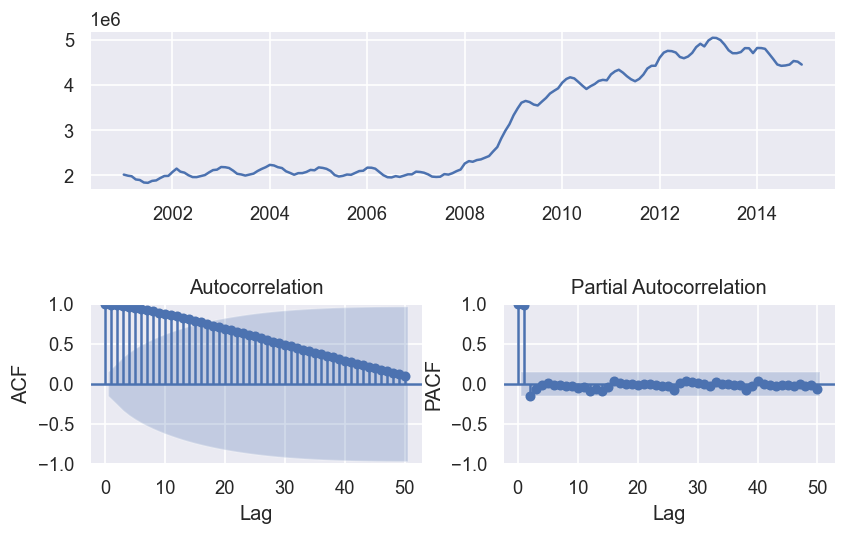

In [62]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train,lags=50)

#### 2. Stabilize the variance (if needed)

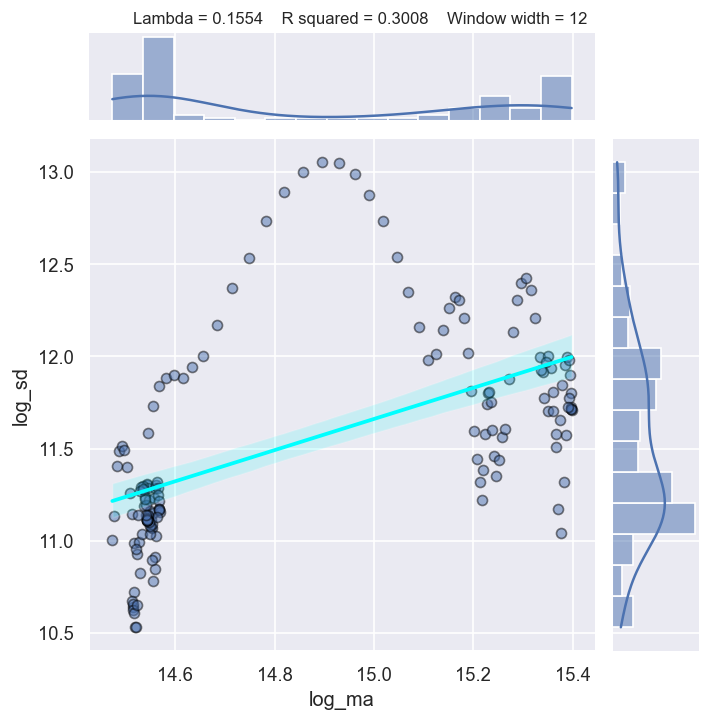

In [63]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train, window_width=12)

En este caso se aprecia una relación entre ambas, pero una no lineal. Por ello, ambas opciones podrían ser correctas, pero decidimos aplicar Box-Cox ya que creemos que puede ayudar ligeramente, y en los modelos no se observan cambios muy relevantes.

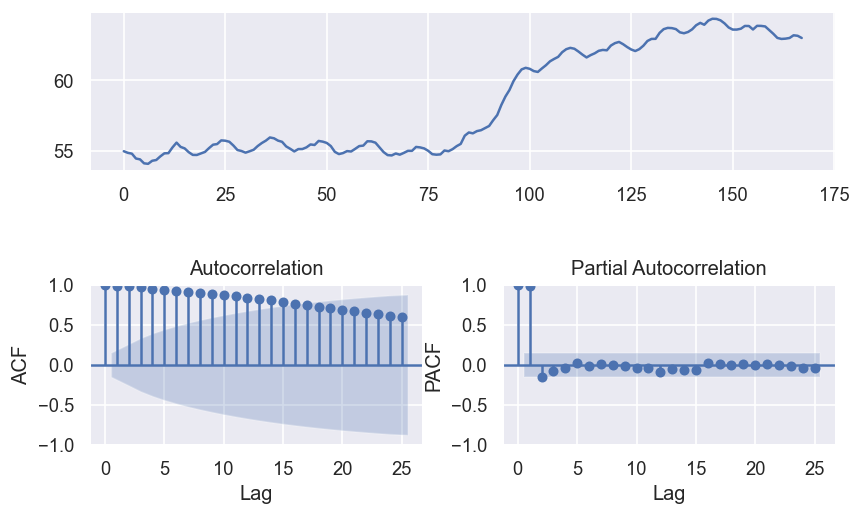

In [64]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train

# Plot transformed data
FT.ts_display(z)

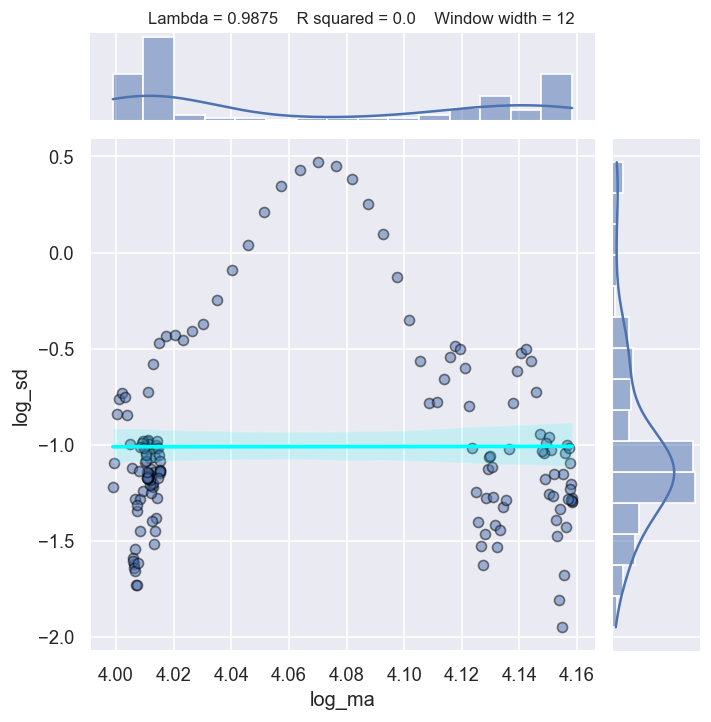

0.9874504401748254

In [65]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [66]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.122944
p-value: 0.705836
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


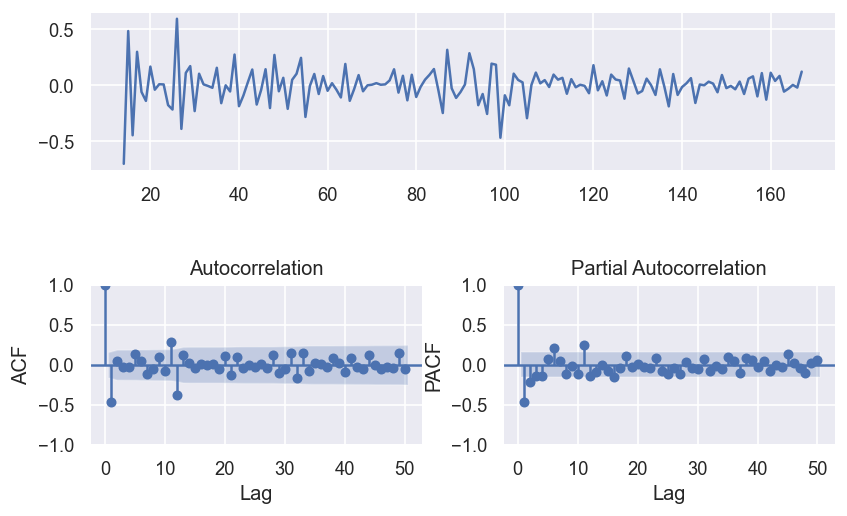

In [67]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Se podría plantear usar solo una diferenciación y aplicar modelos ARMA (se ha comprobado que esto último da ligeramente mejores resultados en entrenamiento, pero peores en test en la predicción y principales métricas).

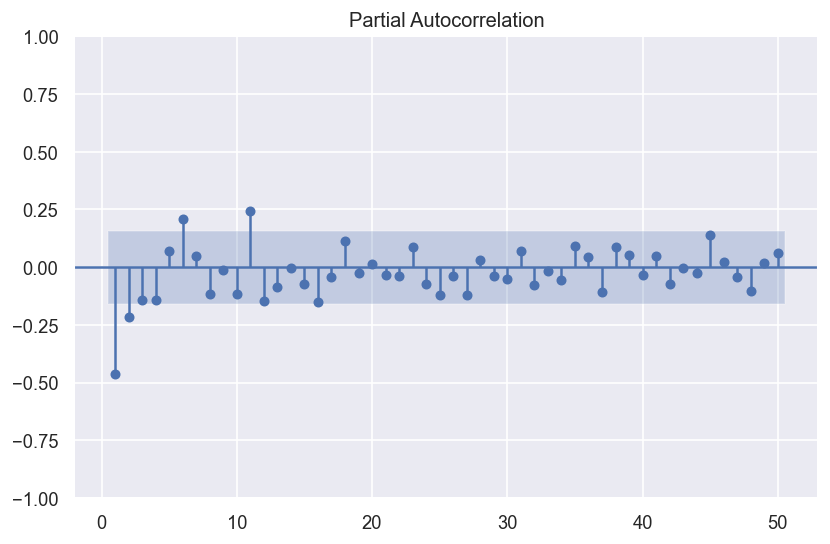

<Figure size 960x600 with 0 Axes>

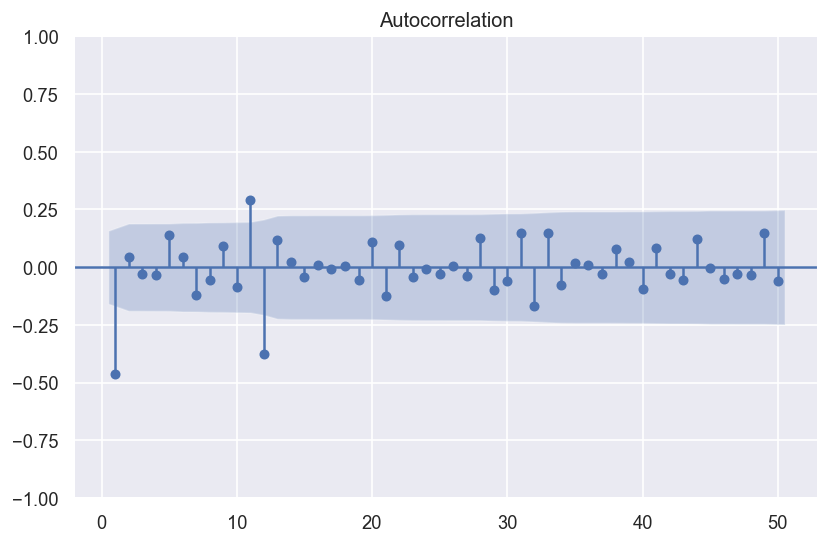

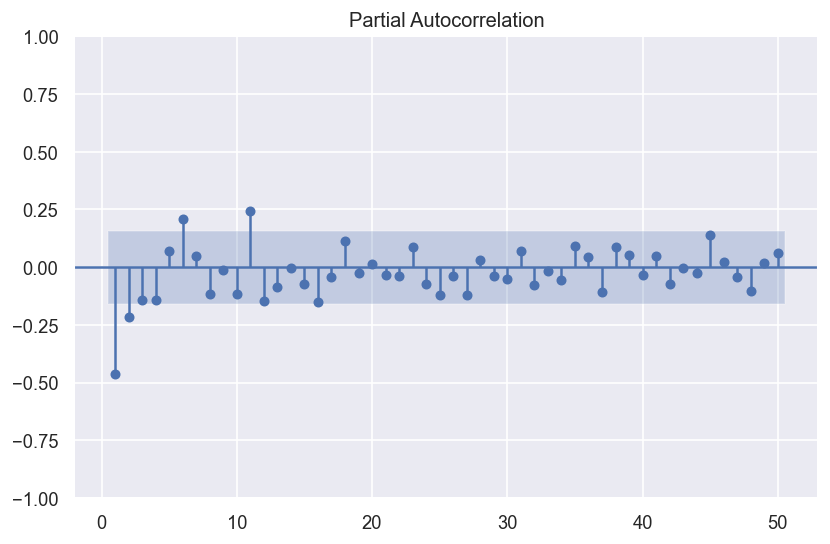

In [68]:
#Bigger plots
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary a moving average model (0,2,1) or an ARMA (1,2,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [84]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  168
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                 119.062
Date:                            Tue, 28 Nov 2023   AIC                           -232.124
Time:                                    10:19:49   BIC                           -223.013
Sample:                                         0   HQIC                          -228.423
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6429      0.051    -12.659      0.000      -0.742      -0.543
ma.S.L12      -0.6845      0.085   

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  29.518312   0.242832


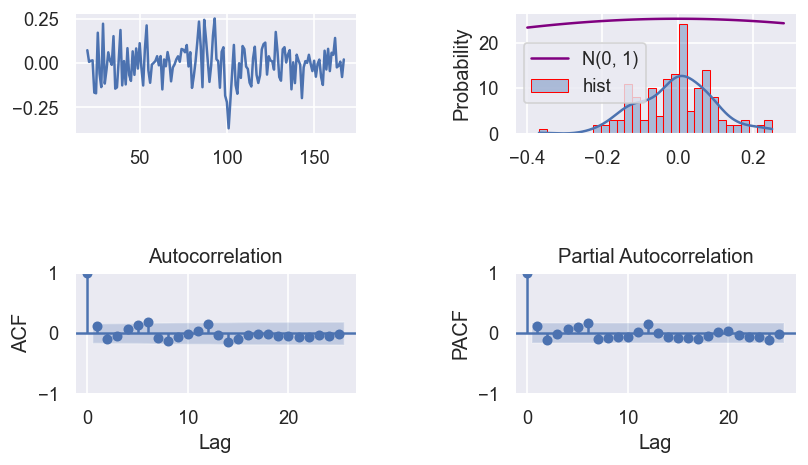

In [85]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el sexto residuo parece algo significativo en el anterior gráfico (Puede ser debido a que no se capte de forma perfecta el efecto estacional).

In [86]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(6,2,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  168
Model:             SARIMAX(6, 2, 0)x(0, 1, [1], 12)   Log Likelihood                 123.401
Date:                              Tue, 28 Nov 2023   AIC                           -230.802
Time:                                      10:19:57   BIC                           -206.506
Sample:                                           0   HQIC                          -220.933
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6647      0.063    -10.484      0.000      -0.789      -0.540
ar.L2         -0.40

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  17.124055   0.877245


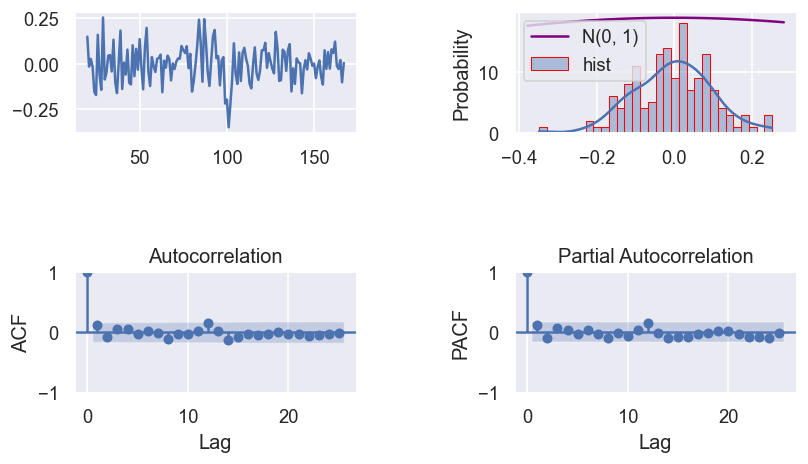

In [87]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Es mejor en términos de error, pero a grandes rasgos parece más correcto el primero. Observamos a continuación su desempeño en test.

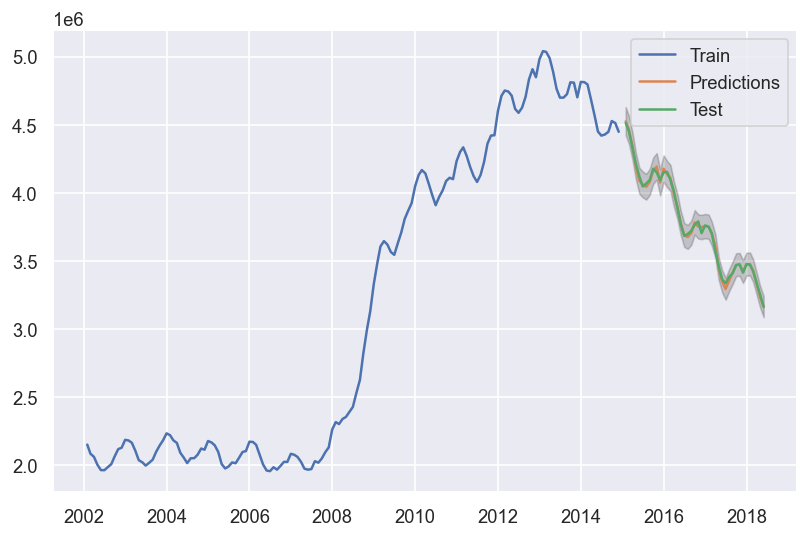

In [114]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

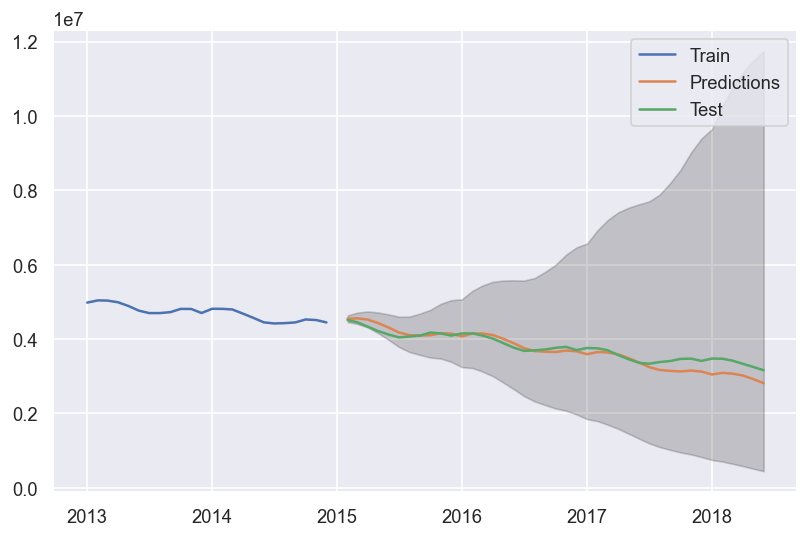

In [89]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0]) + 1
end = round(0.8*y.shape[0])
horizon = end - start

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2013-01-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

Resultados de BIC y AIC para los modelos en test:

In [93]:
pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 2: 145170.04338343945
Test RMSE SARIMA 1 d = 2: 189856.82528421588


In [94]:
# Fit model with estimated order
sarima_fit_aux = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

pred = sarima_fit_aux.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 1: 418341.65131436504
Test RMSE SARIMA 1 d = 1: 476827.036381107


In [95]:
pred = sarima_fit2.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 2: 173266.08768717299
Test RMSE SARIMA 2: 228979.1854434778


Sin duda, el mejor modelo es `sarima_fit` en términos de métricas, simplicidad y residuos, por lo que se usará este modelo a continuación en el conjunto de entrenamiento con prácticamente la totalidad de los datos para reajustar los parámetros sabiendo que es el mejor posible, aplicando los mismos pasos que anteriormente y observando los resultados finales.

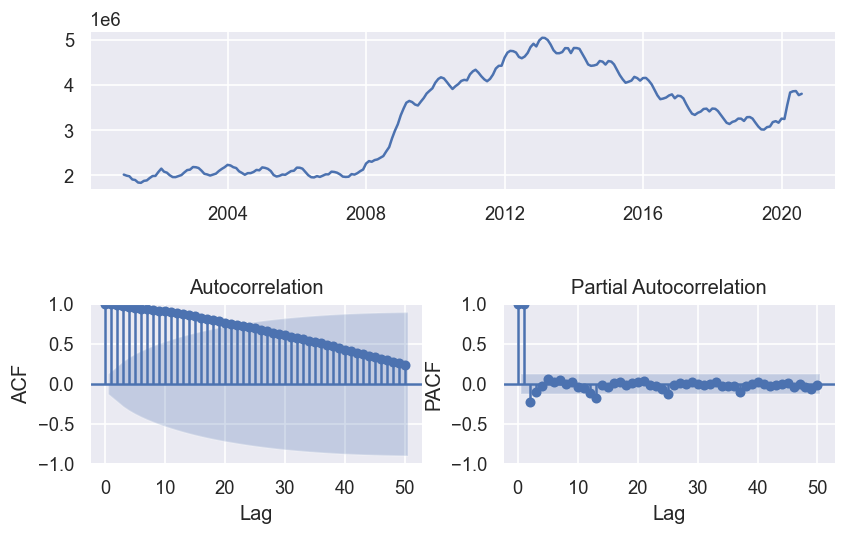

In [103]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train2,lags=50)

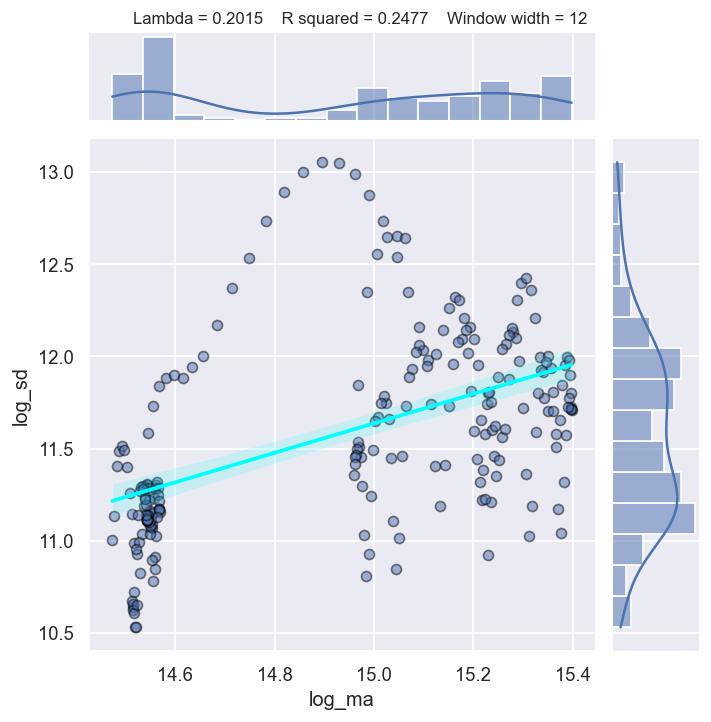

In [104]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

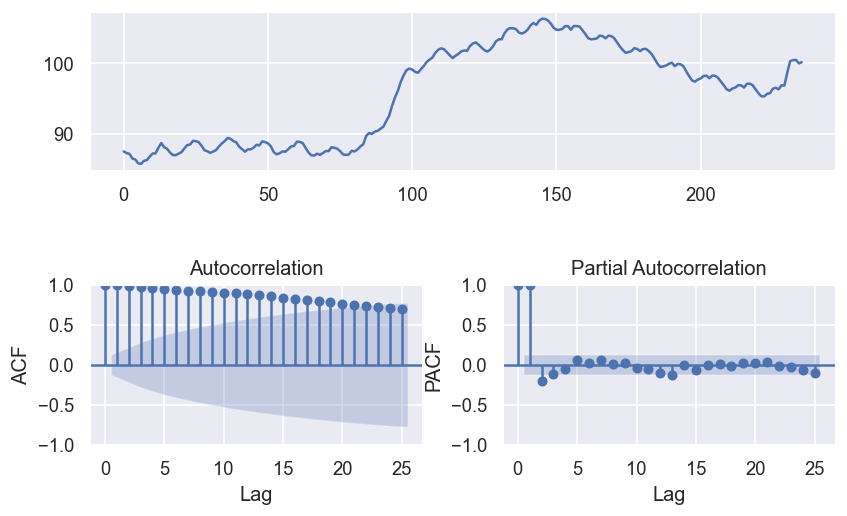

In [105]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train2.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
FT.ts_display(z)

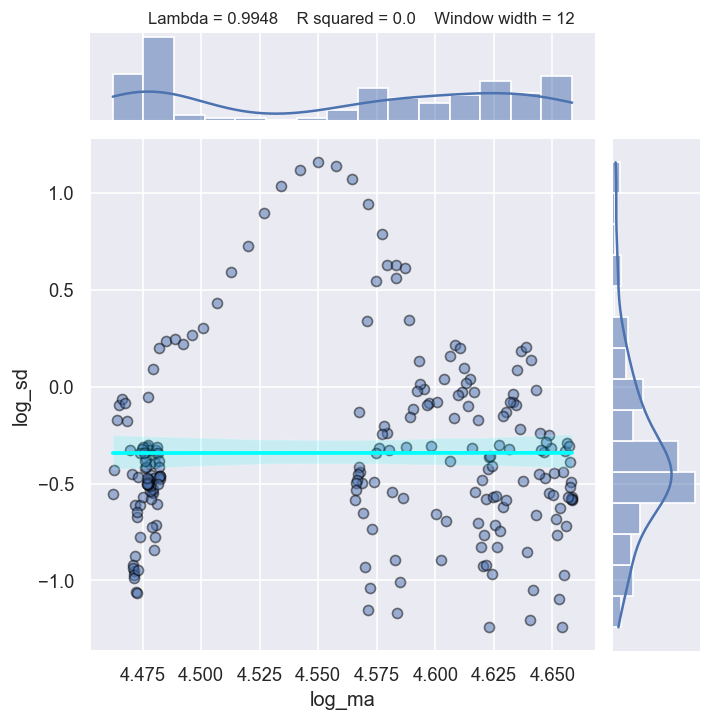

0.9947856536244533

In [106]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [107]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.579868
p-value: 0.493698
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574


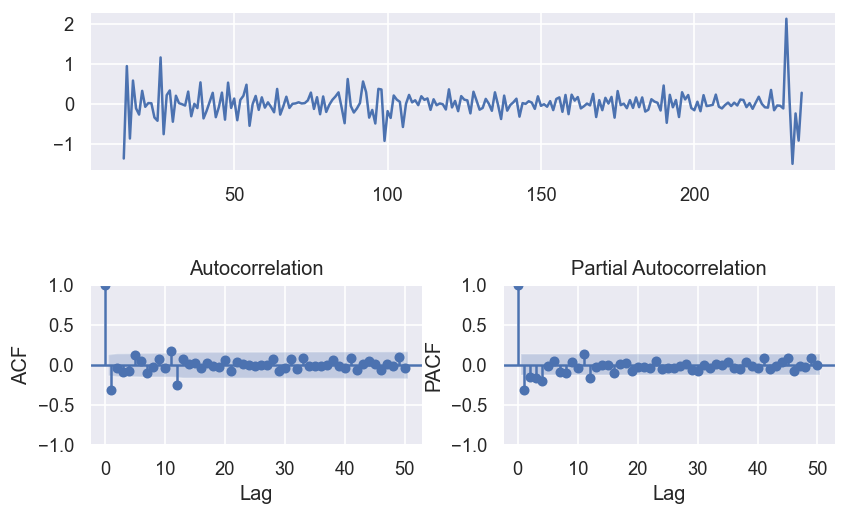

In [108]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Parece que nos lleva a resultados similares, aunque al final de la serie se observa un cambio muy grande en la serie debido a lo anteriormente comentado: el COVID.

In [109]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  236
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                 -18.860
Date:                            Tue, 28 Nov 2023   AIC                             45.721
Time:                                    10:25:27   BIC                             59.331
Sample:                                         0   HQIC                            51.216
                                            - 236                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4120      0.055      7.497      0.000       0.304       0.520
ma.L1         -0.8682      0.041   

Observamos que en este caso admite también un término autorregresivo, siendo éste un pequeño reajuste como los que hablábamos.

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  12.988077   0.976647


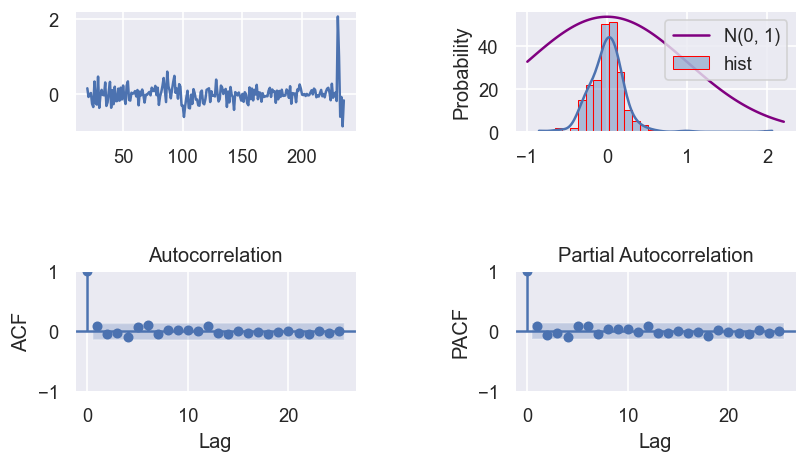

In [110]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

El error es bastante bueno, se observan a continuación diversas métricas y la predicción.

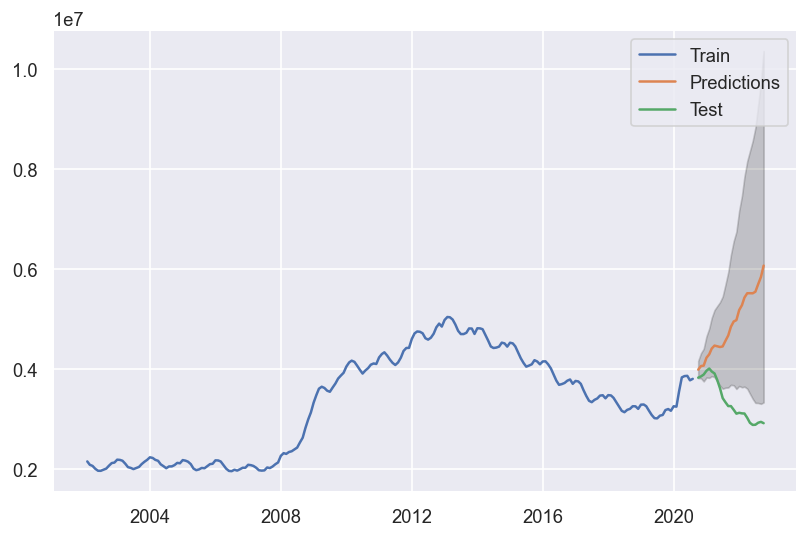

In [116]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.9*y.shape[0])
end = round(y.shape[0])
horizon = end - round(0.9*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

Como se puede observar, la predicción es bastante mala, no captando en absoluto la bajada. Por tanto, se pueden probar otros modelos como el inicial (0,2,1) o el otro posible comentado al comienzo con una diferenciación (1,1,1). El primero mejora algo los errores, pero sigue sin captar la tendencia. El segundo, sin embargo, además de ser más sencillo, sus resultados son mejores, pero tiene una explicación.

In [117]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 1530571.2756780398
Test RMSE SARIMA 1 d = 2: 1821466.3490837994


In [133]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  236
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -18.408
Date:                            Tue, 28 Nov 2023   AIC                             44.817
Time:                                    10:33:44   BIC                             58.445
Sample:                                         0   HQIC                            50.319
                                            - 236                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7478      0.053     14.046      0.000       0.643       0.852
ma.L1         -0.2126      0.066   

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  12.528989   0.981768


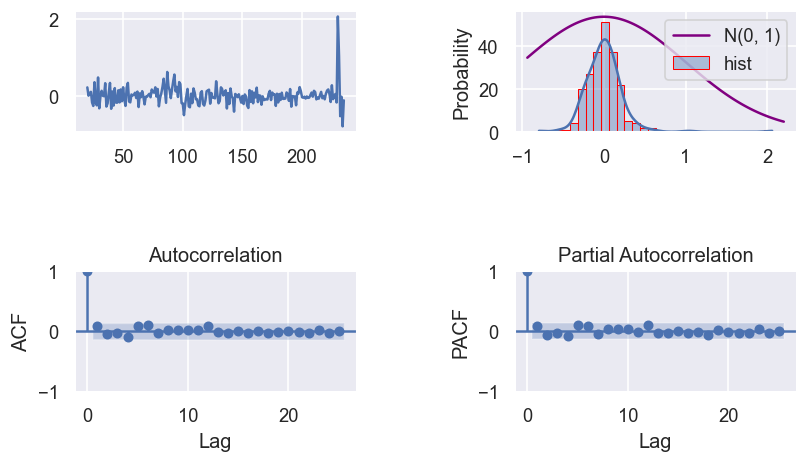

In [131]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

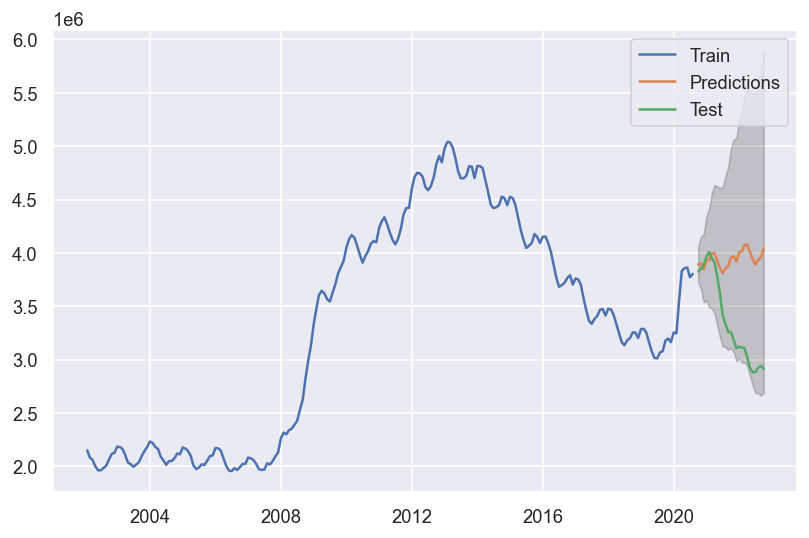

In [134]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.9*y.shape[0])
end = round(y.shape[0])
horizon = end - round(0.9*y.shape[0])

pred = sarima_fit2.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [135]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 588757.6165330331
Test RMSE SARIMA 1 d = 2: 719631.3164693714


Como se puede observar, este modelo menos complejo simplemente sigue con mayor exactitud los últimos datos reales, por lo que su menor error es pura coincidencia, fruto de la bajada repentina, pero no quiere decir que en general sea un mejor modelo o sobreajuste menos que los anteriores. De hecho, parecen modelos más precisos los previos, pero claramente ninguno es capaz de capturar esa gran bajada, como es lógico.

No obstante, los residuos son claramente independientes en todos los casos, y no se observa ningún retardo significativo. No obstante, se puede ver un gran outlier que, junto con lo comentado anteriormente, nos indica de la gran necesidad de añadir algún tipo de tendencia o parámetro para modelar los efectos del COVID como, por ejemplo, una variable de intervención. Por tanto, ése será el siguiente paso.

# **PONER ALGUN TITULITO DE VARIABLE INTERVENCION Y BLABLABLA; EXPLICAR LA DUMMY Y POCO MAS**

In [118]:
df['Periodo_Covid'] = 0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin = pd.to_datetime('2022-07-01') #Parece que aquí termina su influencia en nuestra serie

# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin, 'Periodo_Covid'] = 1

In [ ]:
INPUTS_SARMAX = ['COVID']

# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = y_train, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,4),
                            exog = X_train[INPUTS_SARMAX])
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

In [ ]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid),lags=50)